# Metadata

```yaml
Course:    DS 5001 
Module:    12 Lab
Topic:     Classification with Perceptron
Author:    R.C. Alvarado
Date:      16 April 2023 (revised)
```

# Overview 

1. $X \rightarrow x$
2. $x \dot W = y^\prime$
3. $f(y^\prime) = y$ 

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_prefix = 'winereviews'
data_path = f"{data_home}/{data_prefix}/{data_prefix}"

## Import

In [3]:
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn.linear_model import LogisticRegression

# Preparation

## Get Data

In [4]:
X_test = pd.read_pickle(f"{data_path}-X_test.csv.pickle").sort_index()
X_train = pd.read_pickle(f"{data_path}-X_train.csv.pickle").sort_index()
y_test = pd.read_pickle(f"{data_path}-y_test.csv.pickle").sort_index()
y_train = pd.read_pickle(f"{data_path}-y_train.csv.pickle").sort_index()

In [26]:
DOC = pd.read_csv(f"{data_path}-DOC_UNSPLIT.csv").set_index('doc_id')

# Training

In [5]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# Testing

In [6]:
y_hat = pd.DataFrame(clf.predict(X_test), index=X_test.index)

# Evaluation

In [7]:
clf.score(X_test, y_test)

0.827

In [8]:
RESULT = pd.concat([y_test, y_hat], axis=1)
RESULT.columns = ['doc_label', 'prediction']

In [9]:
RESULT['result'] = RESULT.doc_label == RESULT.prediction

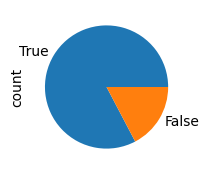

In [10]:
RESULT.value_counts('result').plot.pie(figsize=(2,2));

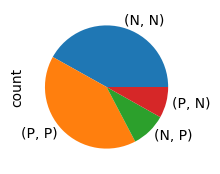

In [11]:
RESULT.value_counts(['prediction','doc_label']).plot.pie(figsize=(2,2));

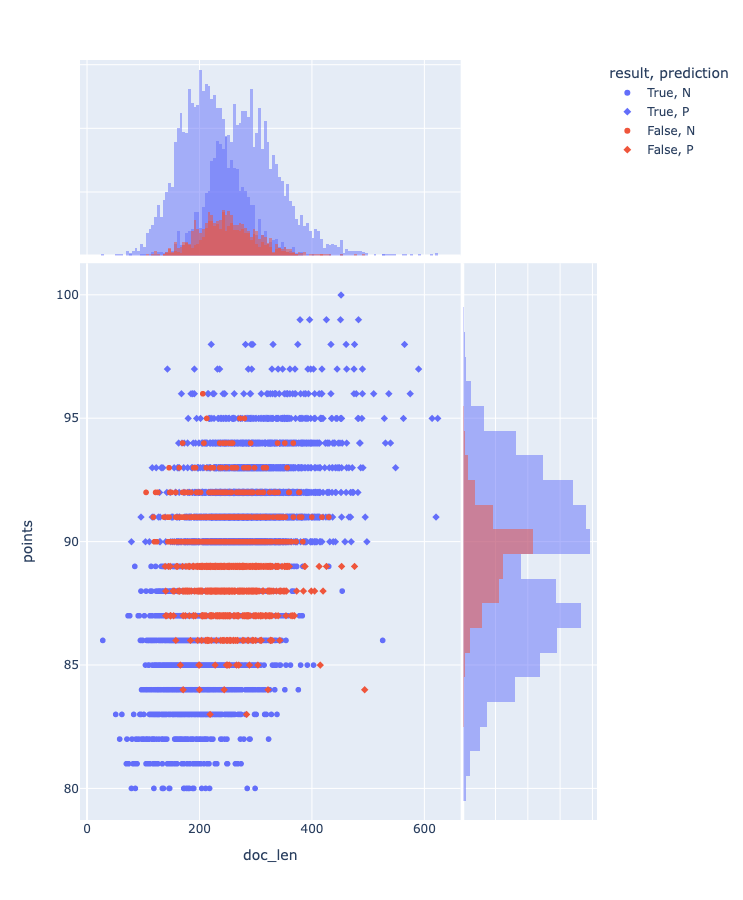

In [28]:
px.scatter(RESULT.join(DOC[['doc_content','points','doc_len']], how='inner').reset_index(), 'doc_len', 'points', color='result', symbol='prediction',
           height=900, width=1000, marginal_x='histogram', marginal_y='histogram')

In [12]:
CM = RESULT.value_counts(['prediction','doc_label']).unstack()

In [13]:
CM

doc_label,N,P
prediction,,
N,3352,733
P,651,3264


In [14]:
def get_results(CM, model_id):
    
    R = pd.DataFrame(index=[model_id])
    R.index.name = 'model_id'
    
    # COUNTS
    R['TN'] = CM.iloc[0,0]   # correct rejections
    R['FN'] = CM.iloc[0,1]   # Type II errors or misses
    R['TP'] = CM.iloc[1,1]   # hits
    R['FP'] = CM.iloc[1,0]   # Type I errors or false alarms
    R['T'] = R.TP + R.TN     # All True
    R['F'] = R.FP + R.FN     # All False
    R['ALL'] = R['T'] + R.F  # All
    
    assert R.ALL.values[0] == CM.sum().sum()
    
    # RATIOS
    R['ACC'] = R['T'] / R.ALL                        # (Simple) Accuracy
    R['TPR'] = R.TP / (R.TP + R.FN)                  # Recall or Sensitivity
    R['TNR'] = R.TN / (R.TN + R.FP)                  # Specificity
    R['PPV'] = R.TP / (R.TP + R.FP)                  # Precision or Positive predictive value 
    R['BA'] = (R.TNR + R.TPR) / 2                    # Balanced Accuracy
    R['F1'] = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN) # F-score where F = 1

    return R

In [15]:
R = get_results(CM, 'logreg')

In [16]:
R.T.style.format(precision=3)

model_id,logreg
TN,3352.000
FN,733.000
TP,3264.000
FP,651.000
T,6616.000
F,1384.000
ALL,8000.000
ACC,0.827
TPR,0.817
TNR,0.837


# Extract Sentiment

We treat weight as valence.

In [17]:
SALEX = pd.DataFrame(clf.coef_, columns=X_test.columns).T.rename(columns={0:'valence'})
SALEX.index.name = 'term_str'
SALEX = SALEX.sort_values('valence')
SALEX['polarity'] = np.sign(SALEX['valence'])

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler(feature_range=(-1, 1))
SALEX['normalized'] = scaler.fit_transform(SALEX[['valence']])

In [20]:
SALEX.sort_values('valence', ascending=False).head(20)

,valence,polarity,normalized
term_str,,,
92,3.588241,1.0,1.000000
91,3.202763,1.0,0.861806
2024,2.478068,1.0,0.602003
2025,2.327596,1.0,0.548058
2022,2.263144,1.0,0.524952
2023,2.201358,1.0,0.502802
2021,2.201180,1.0,0.502738
terrific,2.112757,1.0,0.471038
2028,2.088865,1.0,0.462473


In [21]:
SALEX.sort_values('valence', ascending=True).head(20)

,valence,polarity,normalized
term_str,,,
lacks,-1.990552,-1.0,-1.000000
simple,-1.786412,-1.0,-0.926816
easygoing,-1.730746,-1.0,-0.906859
everyday,-1.695054,-1.0,-0.894064
short,-1.599931,-1.0,-0.859962
livermore,-1.599775,-1.0,-0.859906
flaws,-1.548438,-1.0,-0.841502
appropriate,-1.521101,-1.0,-0.831702
sort,-1.516444,-1.0,-0.830032


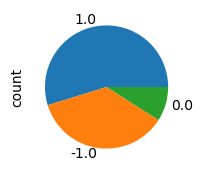

In [22]:
SALEX.polarity.value_counts().plot.pie(figsize=(2,2));

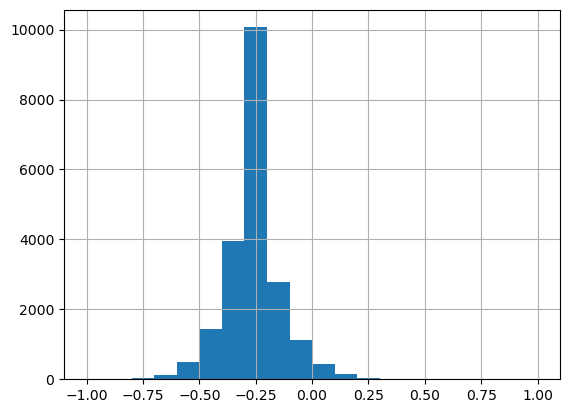

In [23]:
SALEX.normalized.hist(bins=20);

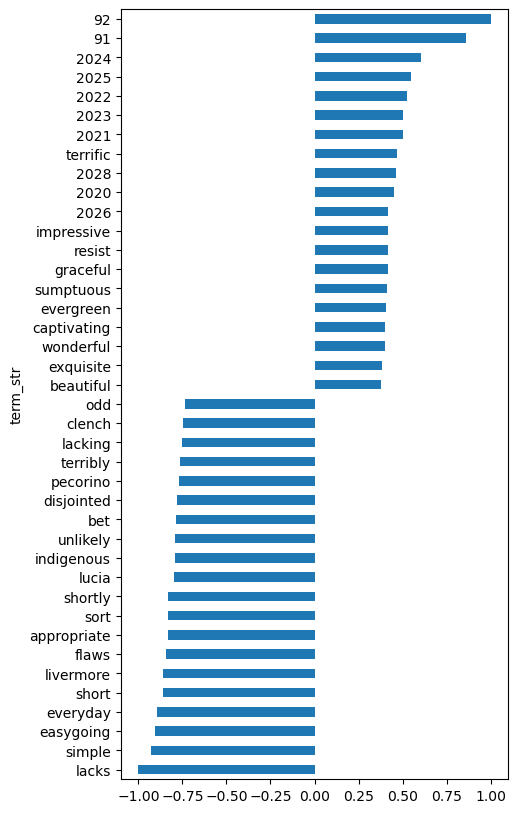

In [24]:
pd.concat([SALEX.normalized.head(20),SALEX.normalized.tail(20)]).plot.barh(figsize=(5,10));

# Save

In [25]:
SALEX.to_csv(f'{data_path}-LOGREG_SALEX.csv')
R.to_csv(f"{data_path}-LOGREG_RESULT.csv", index=True)